In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa')
os.getcwd()

'/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa'

In [ ]:
# Import libraries
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from sklearn.metrics import log_loss, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
# Get csv file
df = pd.read_csv('/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/LabelEncoded.csv')
df.head()

,Id,File,StartRC,EndRC,Status,Class
0,0,101,0.036,1.907,1,0
1,1,101,1.907,4.521,0,0
2,2,101,4.521,7.193,1,0
3,3,101,7.193,9.750,0,0
4,4,101,9.750,12.407,1,0


In [ ]:
def append_ext(id):
    return id+".png"

df_for_model = df[["Id","Class"]].astype("str")
df_for_model["Id"]=df_for_model["Id"].apply(append_ext)
df_for_model.head()

,Id,Class
0,0.png,0
1,1.png,0
2,2.png,0
3,3.png,0
4,4.png,0


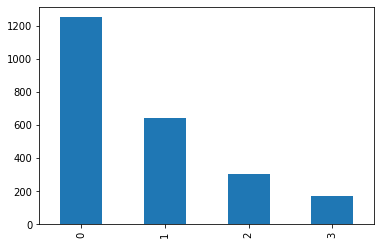

In [ ]:
df_for_model['Class'].value_counts().plot.bar()

In [ ]:
total = df_for_model.shape[0]
print(f"Kelas 0 = {df_for_model['Class'].value_counts()[0]} ({round((df_for_model['Class'].value_counts()[0]/total)*100,2)}%)")
print(f"Kelas 1 = {df_for_model['Class'].value_counts()[1]} ({round((df_for_model['Class'].value_counts()[1]/total)*100,2)}%)")
print(f"Kelas 2 = {df_for_model['Class'].value_counts()[2]} ({round((df_for_model['Class'].value_counts()[2]/total)*100,2)}%)")
print(f"Kelas 3 = {df_for_model['Class'].value_counts()[3]} ({round((df_for_model['Class'].value_counts()[3]/total)*100,2)}%)")

Kelas 0 = 1251 (52.81%)
Kelas 1 = 642 (27.1%)
Kelas 2 = 304 (12.83%)
Kelas 3 = 172 (7.26%)


In [ ]:
train_validate_df, final_test_df = train_test_split(df_for_model, test_size=0.15, stratify = df_for_model['Class'].values, random_state=42)

train_validate_df = train_validate_df.reset_index(drop=True)
final_test_df = final_test_df.reset_index(drop=True)

train_validate_df.to_csv('/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/trainval.csv', index=False)
final_test_df.to_csv('/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/test.csv', index=False)

In [ ]:
def augmentasiTrain(training_df):
  def append_psf(id):
      return "Pitch Shift FoHS/"+id

  def append_tsn(id):
      return "Time Stretch NoLim/"+id
  
  def append_tss(id):
      return "Time Stretch SaLim/"+id

  df_PSF = training_df.copy()
  df_PSF["Id"]=df_PSF["Id"].apply(append_psf)
  df_TSN = training_df.copy()
  df_TSN["Id"]=df_TSN["Id"].apply(append_tsn)
  df_TSS = training_df.copy()
  df_TSS["Id"]=df_TSS["Id"].apply(append_tss)
  return pd.concat([training_df,df_PSF,df_TSN,df_TSS],ignore_index=True)

In [ ]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color
IMAGE_SIZE_INPUT = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

batch_size=15

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

final_test_generator = datagen.flow_from_dataframe(
    final_test_df, 
    "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 356 validated image filenames belonging to 4 classes.


In [ ]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=patience_lr, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    return [mcp_save, learning_rate_reduction]

In [ ]:
def get_model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding='same', activation='elu', input_shape=IMAGE_SIZE_INPUT))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='elu')) 
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='elu'))
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
from sklearn.model_selection import cross_validate

with tf.device('/device:GPU:0'):  

  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
  X = train_validate_df["Id"].values
  y = train_validate_df["Class"].values
  i = 1
  for train_index, test_index in skf.split(X, y):
    print(f"====================***   K-Fold {i}   ***====================")
    i+=1
    # Make Train and Validation DataFrame 
    TrainVal_dict = {"Id": X[train_index],"Class":y[train_index]}
    TrainVal_df = pd.DataFrame(TrainVal_dict)
    Train_df, Valid_df = train_test_split(TrainVal_df, test_size=0.30, stratify = TrainVal_df['Class'].values, random_state=42)
    Train_df = Train_df.reset_index(drop=True)
    Valid_df = Valid_df.reset_index(drop=True)
    Train_df = augmentasiTrain(Train_df)

    # Make Test DataFrame
    Test_dict = {"Id": X[test_index],"Class":y[test_index]}
    Test_df = pd.DataFrame(Test_dict)
    Test_df = Test_df.reset_index(drop=True)

    # Prepare the image
    Train_generator = datagen.flow_from_dataframe(
      Train_df, 
      "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
      x_col='Id',
      y_col='Class',
      target_size=IMAGE_SIZE,
      class_mode="categorical",
      batch_size=batch_size
    )
    Valid_generator = datagen.flow_from_dataframe(
      Valid_df, 
      "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
      x_col='Id',
      y_col='Class',
      target_size=IMAGE_SIZE,
      class_mode="categorical",
      batch_size=batch_size
    )
    Test_generator = datagen.flow_from_dataframe(
      Test_df, 
      "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
      x_col='Id',
      y_col='Class',
      target_size=IMAGE_SIZE,
      class_mode="categorical",
      batch_size=1
    )

    # Callbacks
    name_weights = "final_model_fold" + str(i) + "_weights.h5"
    callbacks = get_callbacks(name_weights=name_weights, patience_lr=2)

    # Fitting
    model = get_model()
    history = model.fit(
      Train_generator, 
      epochs=15,
      validation_data=Valid_generator,
      validation_steps=Valid_df.shape[0]//batch_size,
      steps_per_epoch=Train_df.shape[0]//batch_size,
      callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(Test_generator, verbose=2)

    print(f'\nTest accuracy: {test_acc} \t Test loss: {test_loss}\n\n')

====================***   K-Fold 1   ***====================
Found 5068 validated image filenames belonging to 4 classes.
Found 544 validated image filenames belonging to 4 classes.
Found 202 validated image filenames belonging to 4 classes.
Epoch 1/15
337/337 [==============================] - 1435s 4s/step - loss: 5.6503 - accuracy: 0.4271 - val_loss: 1.2696 - val_accuracy: 0.5296 - lr: 5.0000e-04
Epoch 2/15
337/337 [==============================] - 38s 114ms/step - loss: 1.3351 - accuracy: 0.4813 - val_loss: 1.1237 - val_accuracy: 0.5278 - lr: 5.0000e-04
Epoch 3/15
337/337 [==============================] - ETA: 0s - loss: 1.2239 - accuracy: 0.4997
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
337/337 [==============================] - 37s 111ms/step - loss: 1.2239 - accuracy: 0.4997 - val_loss: 1.1621 - val_accuracy: 0.5296 - lr: 5.0000e-04
Epoch 4/15
337/337 [==============================] - 37s 110ms/step - loss: 1.1506 - accuracy: 0.5167 - val

In [ ]:
final_train_df, final_validate_df = train_test_split(train_validate_df, test_size=0.22, stratify = train_validate_df['Class'].values, random_state=42)

print(f'Jumlah data train : {len(final_train_df)} ( {round(len(final_train_df)/len(df_for_model)*100,2)} % )')
print(f'Jumlah data validasi : {len(final_validate_df)} ( {round(len(final_validate_df)/len(df_for_model)*100,2)} % )')
print(f'Jumlah data test : {len(final_test_df)} ( {round(len(final_test_df)/len(df_for_model)*100,2)} % )')

Jumlah data train : 1570 ( 66.27 % )
Jumlah data validasi : 443 ( 18.7 % )
Jumlah data test : 356 ( 15.03 % )


In [ ]:
final_train_df = final_train_df.reset_index(drop=True)
final_validate_df = final_validate_df.reset_index(drop=True)
final_train_df_augmented = augmentasiTrain(final_train_df)
print(f'Jumlah data train setelah ditambah augmentasi : {len(final_train_df_augmented)}')

Jumlah data train setelah ditambah augmentasi : 6280


In [ ]:
final_train_generator = datagen.flow_from_dataframe(
    final_train_df_augmented, 
    "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size
)

final_validate_generator = datagen.flow_from_dataframe(
    final_validate_df, 
    "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size
)

Found 6280 validated image filenames belonging to 4 classes.
Found 443 validated image filenames belonging to 4 classes.


In [ ]:
with tf.device('/device:GPU:0'): 
    # Callbacks
    name_weights = "CNN_with_CrossVal_final_model_weights.h5"
    callbacks = get_callbacks(name_weights=name_weights, patience_lr=2)

    # Fitting
    model = get_model()
    history = model.fit(
      final_train_generator, 
      epochs=60,
      validation_data=final_validate_generator,
      validation_steps=final_validate_df.shape[0]//batch_size,
      steps_per_epoch=final_train_df_augmented.shape[0]//batch_size,
      callbacks=callbacks
    )

Epoch 1/60
418/418 [==============================] - 67s 161ms/step - loss: 5.3998 - accuracy: 0.4211 - val_loss: 1.1757 - val_accuracy: 0.5310 - lr: 5.0000e-04
Epoch 2/60
418/418 [==============================] - 45s 108ms/step - loss: 1.2965 - accuracy: 0.4886 - val_loss: 1.1789 - val_accuracy: 0.5287 - lr: 5.0000e-04
Epoch 3/60
418/418 [==============================] - 46s 109ms/step - loss: 1.3051 - accuracy: 0.5074 - val_loss: 1.1708 - val_accuracy: 0.5333 - lr: 5.0000e-04
Epoch 4/60
418/418 [==============================] - 47s 112ms/step - loss: 1.2319 - accuracy: 0.5180 - val_loss: 1.1372 - val_accuracy: 0.5287 - lr: 5.0000e-04
Epoch 5/60
418/418 [==============================] - ETA: 0s - loss: 1.2057 - accuracy: 0.5172
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
418/418 [==============================] - 46s 109ms/step - loss: 1.2057 - accuracy: 0.5172 - val_loss: 1.2089 - val_accuracy: 0.5287 - lr: 5.0000e-04
Epoch 6/60
418/418 [=====

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 56, 56, 128)      

In [ ]:
test_loss, test_acc = model.evaluate(final_test_generator, verbose=2)

print(f'\nTest accuracy: {test_acc} \t Test loss: {test_loss}\n\n')

356/356 - 127s - loss: 0.6328 - accuracy: 0.7809

Test accuracy: 0.7808988690376282 	 Test loss: 0.6328259706497192




In [ ]:
# Save Model
# Save the weights
model.save_weights('Lung_Classification_model_weights.h5')

# Save the model architecture
with open('Lung_Classification_model_architecture.json', 'w') as f:
    f.write(model.to_json())

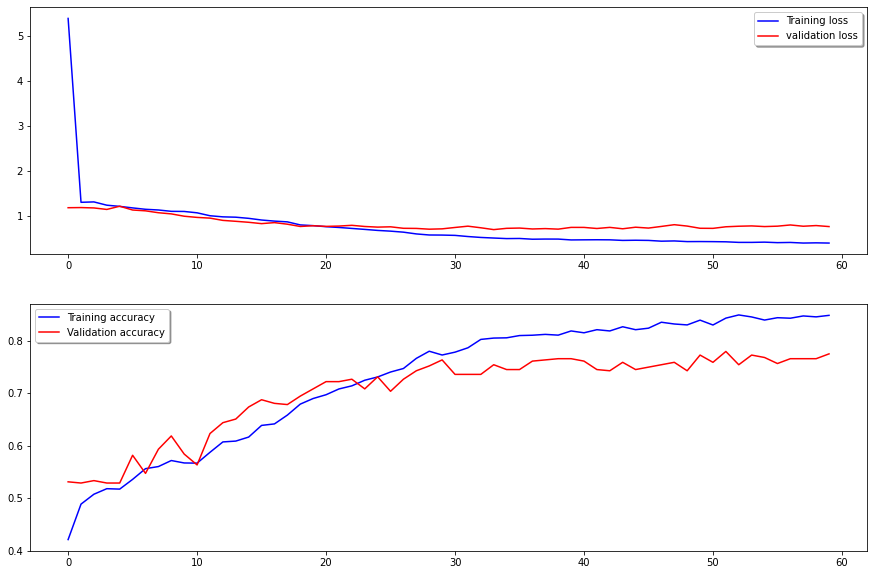

In [ ]:
# Virtualize Training

fig, ax = plt.subplots(2,1)
plt.gcf().set_size_inches(15, 10)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
predict = model.predict(final_test_generator, verbose=2)

Found 356 validated image filenames belonging to 4 classes.
356/356 - 2s


In [ ]:
(final_test_generator.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3}

In [ ]:
predict_dec = predict.argmax(axis=-1)
predict_dec = list(map(str,predict_dec))
print(predict_dec)

['2', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '3', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '2', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '2', '0', '2', '0', '3', '1', '2', '1', '2', '1', '3', '0', '2', '0', '0', '1', '0', '2', '1', '0', '1', '2', '2', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '2', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '2', '0', '0', '3', '0', '1', '3', '2', '2', '0', '0', '0', '0', '2', '0', '0', '0', '1', '1', '3', '3', '2', '0', '1', '2', '1', '0', '1', '0', '0', '0', '1', '3', '0', '1', '0', '2', '0', '0', '2', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '2', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '2', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '2', '0', '0', '0', '1', '2', '1', '0', '2', '2', '2', '0', '0', '0', '0', '1', '1', '2', '1', '0', '0', '0', '0', '0', '0', '0', '0',

In [ ]:
conf_mat = confusion_matrix(final_test_df["Class"].values, predict_dec)
conf_mat

array([[162,  21,   4,   1],
       [ 28,  67,   0,   1],
       [  9,   1,  35,   1],
       [  3,   1,   8,  14]])

In [ ]:
print(classification_report(final_test_df["Class"].values, predict_dec, target_names=["Normal","Crackle","Wheeze","Crackle and Wheeze"]))

                    precision    recall  f1-score   support

            Normal       0.80      0.86      0.83       188
           Crackle       0.74      0.70      0.72        96
            Wheeze       0.74      0.76      0.75        46
Crackle and Wheeze       0.82      0.54      0.65        26

          accuracy                           0.78       356
         macro avg       0.78      0.71      0.74       356
      weighted avg       0.78      0.78      0.78       356

